# PA004 - HEALTH INSURANCE CROS-SELL

Last version of project, according Machine Learning Fundamentals course

## 0 - IMPORTS AND FUNCTIONS

In [1]:
import pandas              as pd
import scikitplot          as skplt
import matplotlib.pyplot   as plt
import lightgbm            as lgbm

from pandas_profiling      import ProfileReport
from IPython.display       import HTML
from catboost              import CatBoostClassifier
from xgboost               import XGBClassifier
from sklearn               import metrics               as mt
from sklearn               import model_selection       as ms

C:\Users\perot\anaconda3\envs\health_insurance_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\perot\AppData\Local\Temp\ipykernel_11328\769720762.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling      import ProfileReport


### 0.1 - HELPER FUNCTIONS

In [25]:
def ml_performance( model_name, precision_atK, recall_atK, accuracy ):
        
        return pd.DataFrame( {'Model Name': model_name,
                              'Precision_at_K': precision_atK,
                              'Recall_at_K': recall_atK}, index=[0] )
                          
def recall_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 

def precision_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def cross_validation(kfold, modelName, model, data, at_k):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def ml_performance( model_name, precision_atK, recall_atK ):
    
    return pd.DataFrame( {'Model Name': model_name,
                          'Precision_at_K': precision_atK,
                          'Recall_at_K': recall_atK}, index=[0])

## 1 - LOADING AND UNDESTANDING DATA

In [3]:
# All data - Linux
#df = pd.read_csv('/home/reng/Documents/ds_repos/Projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

# All Data - Windows
df = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv') 

### 1.1 - SPLIT DATASET INTO TRAINING, TEST AND VALIDATION

In [4]:
# Applying train test split to create Train, Validation and Test datasets

X = df.drop( 'response', axis=1 )
y = df['response'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.2 )
x_train, x_test, y_train, y_test = ms.train_test_split( x_train, y_train, test_size=0.2, shuffle=True, random_state=None )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")

 x_train: (243909, 11)
 y_train: (243909,)
 x_valid: (76222, 11)
 y_valid: (76222,)
 x_test: (60978, 11)
 y_test: (60978,)



### 1.2 - DATA DESCRIPTION

In [ ]:
#df1 = pd.concat([x_train,y_train], axis=1)

In [ ]:
#prof = ProfileReport(df1)
#prof.to_file(output_file='eda_x_training.html')

In [ ]:
#HTML(filename='eda_x_training.html')

## 2 - FEATURE ENGINEERING

In [5]:
df2 = x_train.copy()

In [6]:
df2['id'] = df2['id'].astype('category')
df2['gender'] = df2['gender'].astype('category')
df2['region_code'] = df2['region_code'].astype('category')
df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('category')
df2['vehicle_age'] = df2['vehicle_age'].astype('category')
df2['vehicle_damage'] = df2['vehicle_damage'].astype('category')
df2['driving_license'] = df2['driving_license'].astype('category')
df2['previously_insured'] = df2['previously_insured'].astype('category')

In [7]:
x_valid['id'] = x_valid['id'].astype('category')
x_valid['gender'] = x_valid['gender'].astype('category')
x_valid['region_code'] = x_valid['region_code'].astype('category')
x_valid['policy_sales_channel'] = x_valid['policy_sales_channel'].astype('category')
x_valid['vehicle_age'] = x_valid['vehicle_age'].astype('category')
x_valid['vehicle_damage'] = x_valid['vehicle_damage'].astype('category')
x_valid['driving_license'] = x_valid['driving_license'].astype('category')
x_valid['previously_insured'] = x_valid['previously_insured'].astype('category')

In [8]:
x_training = df2
x_validation = x_valid
y_validation = y_valid

## 7 - ML MODELS TRAINING

In [9]:
# Parameter "scale_pos_weight" definition

from collections import Counter

# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(y_train)
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.159


#### 7.1.1 - LGBM Baseline Model

In [10]:
# Model Definition
lgbm_base_model = lgbm.LGBMClassifier(scale_pos_weight=estimate)

# Model training
lgbm_baseline = lgbm_base_model.fit( x_training, y_train )

# Model Prediction
yhat_lgbm_baseline = lgbm_baseline.predict_proba( x_validation )

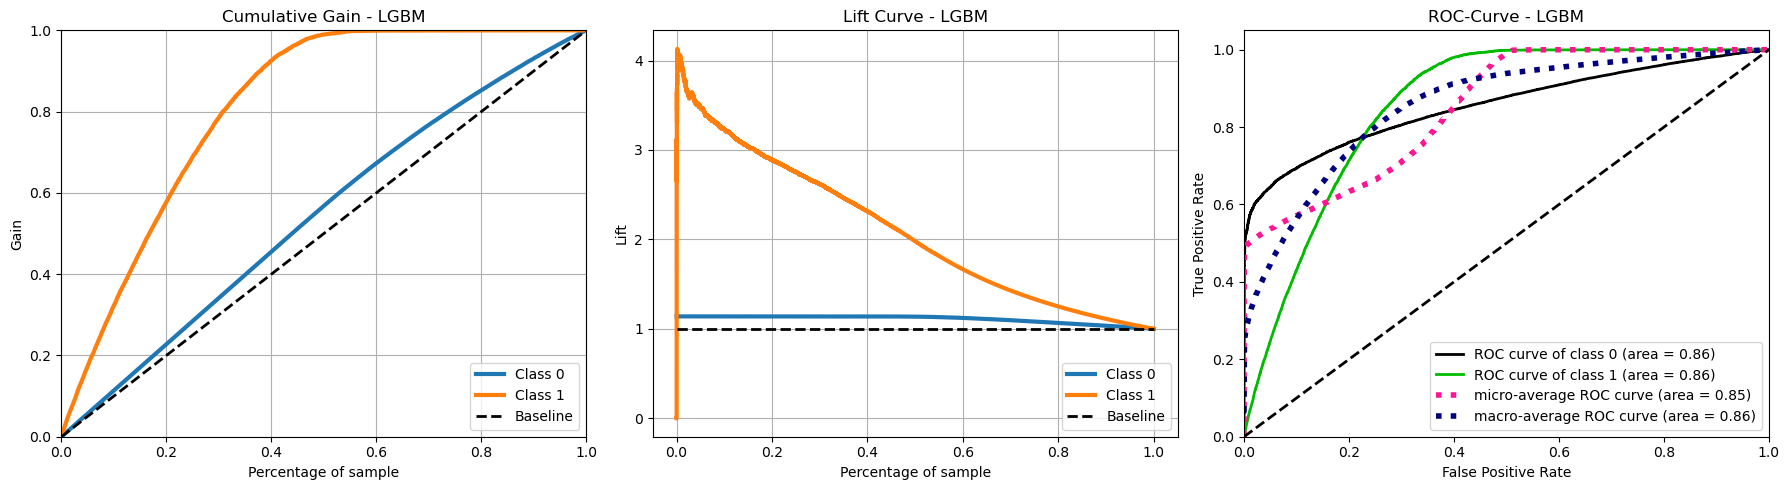

In [11]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm_baseline, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm_baseline,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lgbm_baseline, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [12]:
# Copy Data
perf_valid = x_validation.copy()
perf_valid['response'] = y_validation.copy()

# Propensity score
perf_valid['score'] = yhat_lgbm_baseline[:,1].tolist()

# sorted clients by score
perf_valid = perf_valid.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(perf_valid, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(perf_valid, k=20000 )

lgbm_baseline_performance = ml_performance('LGBM Baseline Model', precision_atK, recall_atK )
lgbm_baseline_performance

,Model Name,Precision_at_K,Recall_at_K
0,LGBM Baseline Model,0.331583,0.713348


#### 7.1.2 - CatBoost Baseline Model

In [15]:
cat_features=['id',
              'gender',
              'region_code',
              'policy_sales_channel',
              'driving_license',
              'vehicle_age',
              'vehicle_damage',
              'previously_insured'   
]

In [16]:
# Model Definition
cb_base_model = CatBoostClassifier(scale_pos_weight=estimate, task_type='GPU')

# Model training
cb_baseline = cb_base_model.fit( x_training, y_train, cat_features)

# Model Prediction
yhat_cb_baseline = cb_baseline.predict_proba( x_validation )

Learning rate set to 0.024916
0:	learn: 0.6700903	total: 34.9ms	remaining: 34.9s
1:	learn: 0.6492579	total: 68ms	remaining: 33.9s
2:	learn: 0.6308190	total: 104ms	remaining: 34.6s
3:	learn: 0.6136530	total: 132ms	remaining: 32.9s
4:	learn: 0.5982693	total: 161ms	remaining: 32s
5:	learn: 0.5841519	total: 188ms	remaining: 31.1s
6:	learn: 0.5714606	total: 214ms	remaining: 30.4s
7:	learn: 0.5596884	total: 239ms	remaining: 29.6s
8:	learn: 0.5489073	total: 275ms	remaining: 30.3s
9:	learn: 0.5392134	total: 298ms	remaining: 29.5s
10:	learn: 0.5305963	total: 323ms	remaining: 29s
11:	learn: 0.5226935	total: 348ms	remaining: 28.6s
12:	learn: 0.5156853	total: 376ms	remaining: 28.5s
13:	learn: 0.5091508	total: 401ms	remaining: 28.2s
14:	learn: 0.5031297	total: 426ms	remaining: 28s
15:	learn: 0.4976751	total: 455ms	remaining: 28s
16:	learn: 0.4926436	total: 485ms	remaining: 28.1s
17:	learn: 0.4880376	total: 513ms	remaining: 28s
18:	learn: 0.4838276	total: 540ms	remaining: 27.9s
19:	learn: 0.4799258	

163:	learn: 0.4188274	total: 4.52s	remaining: 23s
164:	learn: 0.4187914	total: 4.57s	remaining: 23.1s
165:	learn: 0.4187542	total: 4.6s	remaining: 23.1s
166:	learn: 0.4187262	total: 4.62s	remaining: 23s
167:	learn: 0.4186986	total: 4.64s	remaining: 23s
168:	learn: 0.4186472	total: 4.66s	remaining: 22.9s
169:	learn: 0.4186085	total: 4.7s	remaining: 22.9s
170:	learn: 0.4185812	total: 4.72s	remaining: 22.9s
171:	learn: 0.4185490	total: 4.75s	remaining: 22.9s
172:	learn: 0.4185282	total: 4.77s	remaining: 22.8s
173:	learn: 0.4184973	total: 4.81s	remaining: 22.8s
174:	learn: 0.4184682	total: 4.83s	remaining: 22.8s
175:	learn: 0.4184403	total: 4.86s	remaining: 22.7s
176:	learn: 0.4184132	total: 4.88s	remaining: 22.7s
177:	learn: 0.4183905	total: 4.91s	remaining: 22.7s
178:	learn: 0.4183617	total: 4.95s	remaining: 22.7s
179:	learn: 0.4183351	total: 4.99s	remaining: 22.7s
180:	learn: 0.4183041	total: 5.03s	remaining: 22.8s
181:	learn: 0.4182732	total: 5.06s	remaining: 22.7s
182:	learn: 0.418242

325:	learn: 0.4156214	total: 9.23s	remaining: 19.1s
326:	learn: 0.4156097	total: 9.26s	remaining: 19.1s
327:	learn: 0.4155794	total: 9.3s	remaining: 19.1s
328:	learn: 0.4155656	total: 9.33s	remaining: 19s
329:	learn: 0.4155584	total: 9.37s	remaining: 19s
330:	learn: 0.4155404	total: 9.41s	remaining: 19s
331:	learn: 0.4155315	total: 9.44s	remaining: 19s
332:	learn: 0.4155223	total: 9.48s	remaining: 19s
333:	learn: 0.4155089	total: 9.51s	remaining: 19s
334:	learn: 0.4154988	total: 9.54s	remaining: 18.9s
335:	learn: 0.4154888	total: 9.55s	remaining: 18.9s
336:	learn: 0.4154694	total: 9.58s	remaining: 18.8s
337:	learn: 0.4154466	total: 9.61s	remaining: 18.8s
338:	learn: 0.4154370	total: 9.63s	remaining: 18.8s
339:	learn: 0.4154249	total: 9.66s	remaining: 18.7s
340:	learn: 0.4154138	total: 9.69s	remaining: 18.7s
341:	learn: 0.4154021	total: 9.71s	remaining: 18.7s
342:	learn: 0.4153780	total: 9.74s	remaining: 18.7s
343:	learn: 0.4153602	total: 9.76s	remaining: 18.6s
344:	learn: 0.4153419	tot

484:	learn: 0.4135573	total: 13.9s	remaining: 14.8s
485:	learn: 0.4135287	total: 13.9s	remaining: 14.8s
486:	learn: 0.4135216	total: 14s	remaining: 14.7s
487:	learn: 0.4135086	total: 14s	remaining: 14.7s
488:	learn: 0.4135016	total: 14s	remaining: 14.7s
489:	learn: 0.4134930	total: 14.1s	remaining: 14.6s
490:	learn: 0.4134840	total: 14.1s	remaining: 14.6s
491:	learn: 0.4134752	total: 14.1s	remaining: 14.6s
492:	learn: 0.4134738	total: 14.1s	remaining: 14.6s
493:	learn: 0.4134637	total: 14.2s	remaining: 14.5s
494:	learn: 0.4134560	total: 14.2s	remaining: 14.5s
495:	learn: 0.4134439	total: 14.2s	remaining: 14.5s
496:	learn: 0.4134309	total: 14.3s	remaining: 14.4s
497:	learn: 0.4134153	total: 14.3s	remaining: 14.4s
498:	learn: 0.4134025	total: 14.3s	remaining: 14.4s
499:	learn: 0.4133915	total: 14.3s	remaining: 14.3s
500:	learn: 0.4133695	total: 14.3s	remaining: 14.3s
501:	learn: 0.4133619	total: 14.4s	remaining: 14.3s
502:	learn: 0.4133516	total: 14.4s	remaining: 14.2s
503:	learn: 0.4133

646:	learn: 0.4117759	total: 18.4s	remaining: 10s
647:	learn: 0.4117695	total: 18.4s	remaining: 10s
648:	learn: 0.4117514	total: 18.4s	remaining: 9.97s
649:	learn: 0.4117442	total: 18.5s	remaining: 9.95s
650:	learn: 0.4117397	total: 18.5s	remaining: 9.92s
651:	learn: 0.4117235	total: 18.5s	remaining: 9.89s
652:	learn: 0.4117120	total: 18.6s	remaining: 9.86s
653:	learn: 0.4116972	total: 18.6s	remaining: 9.83s
654:	learn: 0.4116830	total: 18.6s	remaining: 9.79s
655:	learn: 0.4116730	total: 18.6s	remaining: 9.76s
656:	learn: 0.4116683	total: 18.6s	remaining: 9.73s
657:	learn: 0.4116521	total: 18.7s	remaining: 9.71s
658:	learn: 0.4116367	total: 18.7s	remaining: 9.67s
659:	learn: 0.4116222	total: 18.7s	remaining: 9.64s
660:	learn: 0.4116097	total: 18.7s	remaining: 9.61s
661:	learn: 0.4116046	total: 18.8s	remaining: 9.58s
662:	learn: 0.4115969	total: 18.8s	remaining: 9.55s
663:	learn: 0.4115917	total: 18.8s	remaining: 9.52s
664:	learn: 0.4115834	total: 18.8s	remaining: 9.49s
665:	learn: 0.41

807:	learn: 0.4100739	total: 22.3s	remaining: 5.3s
808:	learn: 0.4100663	total: 22.3s	remaining: 5.28s
809:	learn: 0.4100579	total: 22.4s	remaining: 5.25s
810:	learn: 0.4100503	total: 22.4s	remaining: 5.22s
811:	learn: 0.4100311	total: 22.4s	remaining: 5.19s
812:	learn: 0.4100216	total: 22.5s	remaining: 5.16s
813:	learn: 0.4100102	total: 22.5s	remaining: 5.14s
814:	learn: 0.4099958	total: 22.5s	remaining: 5.11s
815:	learn: 0.4099783	total: 22.5s	remaining: 5.08s
816:	learn: 0.4099697	total: 22.5s	remaining: 5.05s
817:	learn: 0.4099600	total: 22.6s	remaining: 5.02s
818:	learn: 0.4099487	total: 22.6s	remaining: 4.99s
819:	learn: 0.4099422	total: 22.6s	remaining: 4.96s
820:	learn: 0.4099349	total: 22.6s	remaining: 4.93s
821:	learn: 0.4099230	total: 22.7s	remaining: 4.91s
822:	learn: 0.4099188	total: 22.7s	remaining: 4.88s
823:	learn: 0.4099043	total: 22.7s	remaining: 4.85s
824:	learn: 0.4098966	total: 22.7s	remaining: 4.82s
825:	learn: 0.4098906	total: 22.7s	remaining: 4.79s
826:	learn: 0

973:	learn: 0.4085993	total: 26.4s	remaining: 705ms
974:	learn: 0.4085910	total: 26.4s	remaining: 678ms
975:	learn: 0.4085861	total: 26.5s	remaining: 651ms
976:	learn: 0.4085761	total: 26.5s	remaining: 624ms
977:	learn: 0.4085612	total: 26.5s	remaining: 596ms
978:	learn: 0.4085579	total: 26.5s	remaining: 569ms
979:	learn: 0.4085437	total: 26.6s	remaining: 542ms
980:	learn: 0.4085345	total: 26.6s	remaining: 515ms
981:	learn: 0.4085267	total: 26.6s	remaining: 488ms
982:	learn: 0.4085199	total: 26.6s	remaining: 461ms
983:	learn: 0.4085114	total: 26.7s	remaining: 434ms
984:	learn: 0.4084998	total: 26.7s	remaining: 407ms
985:	learn: 0.4084887	total: 26.7s	remaining: 379ms
986:	learn: 0.4084815	total: 26.7s	remaining: 352ms
987:	learn: 0.4084715	total: 26.8s	remaining: 325ms
988:	learn: 0.4084654	total: 26.8s	remaining: 298ms
989:	learn: 0.4084582	total: 26.8s	remaining: 271ms
990:	learn: 0.4084485	total: 26.8s	remaining: 244ms
991:	learn: 0.4084379	total: 26.9s	remaining: 217ms
992:	learn: 

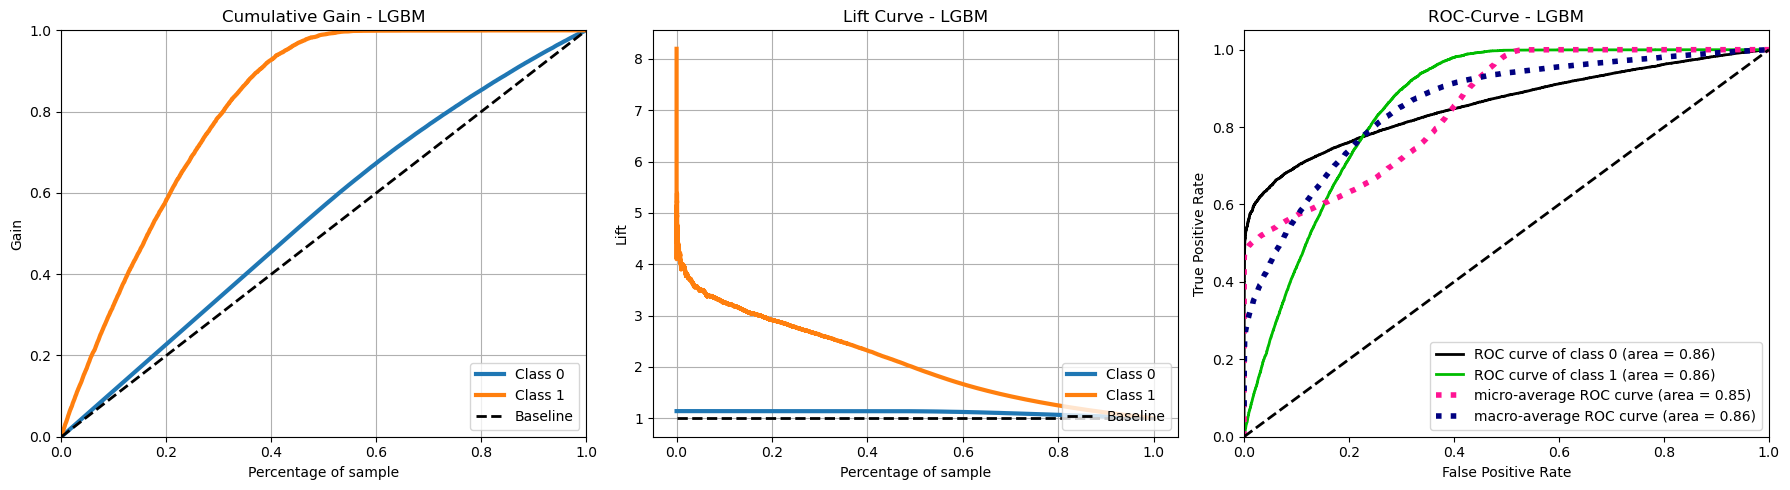

In [17]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_cb_baseline, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_cb_baseline, ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_cb_baseline, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [18]:
# Copy Data
perf_valid = x_validation.copy()
perf_valid['response'] = y_validation.copy()

# Propensity score
perf_valid['score'] = yhat_cb_baseline[:,1].tolist()

# sorted clients by score
perf_valid = perf_valid.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(perf_valid, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(perf_valid, k=20000 )

cb_baseline_performance = ml_performance('CatBoost Baseline Model', precision_atK, recall_atK )
cb_baseline_performance

,Model Name,Precision_at_K,Recall_at_K
0,CatBoost Baseline Model,0.333233,0.716898


#### XGB Classifier Baseline Model

In [19]:
# Model Definition
xgb_base_model = XGBClassifier(scale_pos_weight=estimate, enable_categorical=True, tree_method='gpu_hist')

# Model training
xgb_baseline = xgb_base_model.fit( x_training, y_train )

# Model Prediction
yhat_xgb_baseline = xgb_baseline.predict_proba( x_validation )

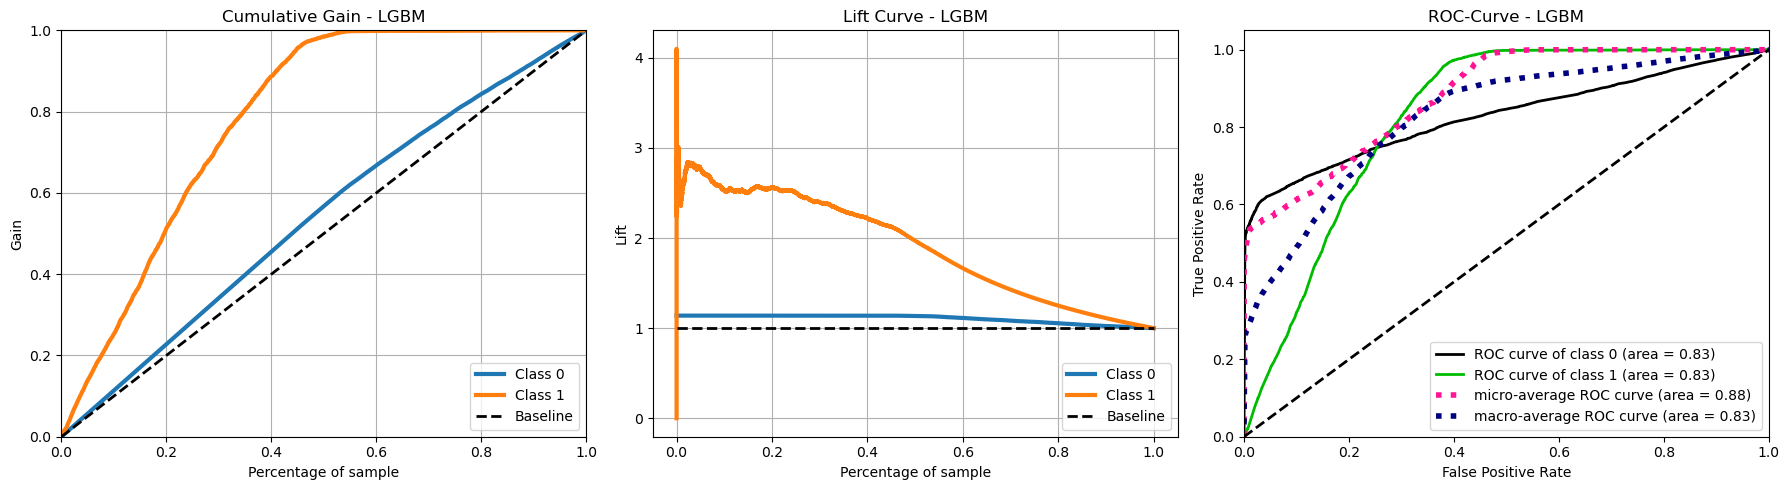

In [20]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb_baseline, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb_baseline, ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_xgb_baseline, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [21]:
# Copy Data
perf_valid = x_validation.copy()
perf_valid['response'] = y_validation.copy()

# Propensity score
perf_valid['score'] = yhat_xgb_baseline[:,1].tolist()

# sorted clients by score
perf_valid = perf_valid.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(perf_valid, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(perf_valid, k=20000 )

xgb_baseline_performance = ml_performance('XGB Baseline Model', precision_atK, recall_atK )
xgb_baseline_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB Baseline Model,0.300235,0.645907


In [22]:
# Baseline Performance for all Machine Leraning Algorithms
baseline_performance = pd.concat( [lgbm_baseline_performance, cb_baseline_performance, xgb_baseline_performance] )
baseline_performance.sort_values('Precision_at_K', ascending= False)

,Model Name,Precision_at_K,Recall_at_K
0,CatBoost Baseline Model,0.333233,0.716898
0,LGBM Baseline Model,0.331583,0.713348
0,XGB Baseline Model,0.300235,0.645907


## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - LGBM Fine Tunning

### 9.2 - CatBoost Fine Tunning

### 9.2 - XGBoost Fine Tunning

###  9.3 - Last model training with all datas

#### 9.3.2.1 - Data preparation applied on validation and test datasets.

In [ ]:
x_test = data_preparation( x_test )

#### 9.3.2.2 - Union of training and validation data.

In [ ]:
x_train_treino = pd.concat([ x_training, x_validation ] )
y_train_treino = pd.concat([ y_train, y_validation ] )

#### 9.3.2.3 - Generalization capacity of LGBM Model

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier(**params )

# Model Training
model_lgbm = lgbm_model.fit( x_train_treino, y_train_treino )

In [ ]:
# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_test )

In [ ]:
# Copy Data
df_test = x_test.copy()
df_test['response'] = y_test.copy()

# Propensity score
df_test['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
df_test = df_test.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df_test, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df_test, k=20000 )

lgbm_performance_cv = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance_cv

In [ ]:
yhat_lgbm_curve = yhat_lgbm[:,1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat_lgbm_curve)

In [ ]:
# plot curves
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.xlabel('thresholds')
plt.ylabel('Precision, Recall')
plt.legend()
plt.show()

#### 9.3.2.4 - Generalization capacity of XGB Model

In [ ]:
# XGB Model

# model definition
model_xgb_cv = XGBClassifier( scale_pos_weight=7.2,
                              colsample_bytree = 0.3,
                              subsample = 0.5,
                              objective='binary:logistic', 
                              n_estimators=1500, 
                              max_depth=3,
                              min_child_weight = 3,
                              eta= 0.03 )

# model training
model_xgb_cv.fit( x_training, y_train )

# model prediction - The generalization POWER
yhat_xgb_cv = model_xgb_cv.predict_proba( x_test )

In [ ]:
# Copy Data
df_test = x_test.copy()
df_test['response'] = y_test.copy()

# Propensity score
df_test['score'] = yhat_xgb_cv[:,1].tolist()

# sorted clients by score
df_test = df_test.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df_test, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df_test, k=20000 )

xgb_performance_cv = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance_cv

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_cv, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_cv,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_xgb_cv, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
yhat_xgb_curve = yhat_xgb_cv[:,1]

In [ ]:
precision, recall, thresholds = precision_recall_curve( y_test, yhat_xgb_curve)

In [ ]:
x_test.shape

In [ ]:
thresholds

In [ ]:
# plot curves
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.xlabel('thresholds')
plt.ylabel('Precision, Recall')
plt.legend()
plt.show()

### 9.1 - Cross Validation

In [23]:
df_cc = pd.concat([x_training, y_train], axis=1)

In [29]:
# Dictioary with models instantiated
models = {'XGB Model': xgb_base_model,
          'LGBM Model': lgbm_base_model,
          'CatBoost Model': cb_base_model}

# Cross-validated models performance
model_performance = pd.DataFrame()

for key in models.keys():
    performance_cv = cross_validation(5, key, models[key], df_cc, 20000)
    model_performance = pd.concat([model_performance, performance_cv], axis=1)

model_performance.T

C:\Users\perot\AppData\Local\Temp\ipykernel_11328\3189285669.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold


ValueError: Feature shape mismatch, expected: 12, got 11

#### 9.3.2.5 - Last training with all datas before deploying to production

In [ ]:
# Union of training, validation and test datasets
df_last = df.copy()

# Split response variable into a new dataset
x_last_training = df_last.drop( 'response', axis=1 )
y_last_training = df_last['response'].copy()

# Applying data transformation
x_last_training = data_preparation( x_last_training )

In [ ]:
# XGB Model Last Training

# model definition
model_xgb_lv= XGBClassifier( scale_pos_weight=7.2,
                              colsample_bytree = 0.3,
                              subsample = 0.5,
                              objective='binary:logistic', 
                              n_estimators=1500, 
                              max_depth=3,
                              min_child_weight = 3,
                              eta= 0.03 )

# model training
model_xgb_lv.fit( x_last_training, y_last_training )

In [ ]:
pickle.dump(model_xgb_lv, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/models/xgb_model.pkl', 'wb'))

## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb') )

    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Changing data types
        df5['region_code'] = df5['region_code'].astype(object)
        df5['policy_sales_channel'] = df5['policy_sales_channel'].astype(object)
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
              
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )


        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # FILL NAN VALUES
        df5 = df5.fillna(0)
        
        # Feature Selection
        cols_selected = ['vintage', 'annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_m odel.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

### 10.3 - API Tester

In [ ]:
import requests
import pandas as pd

In [ ]:
# Load Datasets
df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/test.csv')

In [ ]:
df_test = df_test.sample(10)

In [ ]:
df_test.head()

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'https://healthinsurance-api.onrender.com/healthinsurance/predict'
url = 'http://127.0.0.1:5000/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d2 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )